### Initialization


In [34]:
#Initializations
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import csv

from collections import Counter

# Combining two text files
### Load Text files

In [43]:
#with open('emotion_text.txt', 'r') as file:
with open('train.txt', 'r') as file:
    train_texts = []
    train_labels = []
    for line in file:
        sentence, emotion = line.strip().split(';')
        train_texts.append(sentence.strip())
        train_labels.append(emotion.strip())

print(len(train_texts))
label_counts = Counter(train_labels)
print(label_counts)


# Read validation data
with open('val.txt', 'r') as file:
    val_texts = []
    val_labels = []
    for line in file:
        sentence, emotion = line.strip().split(';')
        val_texts.append(sentence.strip())
        val_labels.append(emotion.strip())

# Read testing data
with open('test.txt', 'r') as file:
    testing_texts = []
    testing_labels = []
    for line in file:
        sentence, emotion = line.strip().split(';')
        testing_texts.append(sentence.strip())
        testing_labels.append(emotion.strip())
        
# Create DataFrames for train, validation, and test data
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'text': testing_texts, 'label': testing_labels})

# Remove rows with 'surprise' label
train_df = train_df[train_df['label'] != 'surprise']
val_df = val_df[val_df['label'] != 'surprise']
test_df = test_df[test_df['label'] != 'surprise']

# Save DataFrames to CSV files
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

print(f"Training data size: {len(train_texts)}")
print(f"Validation data size: {len(val_texts)}")
print(f"Testing data size: {len(testing_texts)}")

16000
Counter({'joy': 5362, 'sadness': 4666, 'anger': 2159, 'fear': 1937, 'love': 1304, 'surprise': 572})
Training data size: 16000
Validation data size: 2000
Testing data size: 2000


In [44]:
# Read the Emotion_classify_Data.csv file
emotion_classify_df = pd.read_csv('Emotion_classify_Data.csv')

# Rename columns
emotion_classify_df.rename(columns={'Comment': 'text', 'Emotion': 'label'}, inplace=True)

# Read the existing train.csv file
train_df = pd.read_csv('train.csv')

# Combine the DataFrames
combined_train_df = pd.concat([train_df, emotion_classify_df], ignore_index=True)

# Save the combined DataFrame back to train.csv
combined_train_df.to_csv('train.csv', index=False)

# Print the first few rows of the combined DataFrame to verify
print(f"Combined training data size: {len(combined_train_df)}")
print(combined_train_df.head())

Combined training data size: 21365
                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


### Read CSV files


In [45]:
with open('train.csv', 'r') as file:
    train_texts = []
    train_labels = []
    reader = csv.reader(file)
    next(reader)  # Skip header if present
    for row in reader:
        sentence, emotion = row
        train_texts.append(sentence.strip())
        train_labels.append(emotion.strip())

print(len(train_texts))
label_counts = Counter(train_labels)
print(label_counts)

# Read validation data from CSV
with open('val.csv', 'r') as file:
    val_texts = []
    val_labels = []
    reader = csv.reader(file)
    next(reader)  # Skip header if present
    for row in reader:
        sentence, emotion = row
        val_texts.append(sentence.strip())
        val_labels.append(emotion.strip())

# Read testing data from CSV
with open('test.csv', 'r') as file:
    testing_texts = []
    testing_labels = []
    reader = csv.reader(file)
    next(reader)  # Skip header if present
    for row in reader:
        sentence, emotion = row
        testing_texts.append(sentence.strip())
        testing_labels.append(emotion.strip())

21365
Counter({'joy': 7362, 'sadness': 4666, 'anger': 4159, 'fear': 3874, 'love': 1304})


### Fine tuning

In [ ]:
# Fine-tuning BERT for text classification
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=13)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Tokenize texts and convert to PyTorch tensors
encoding = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Convert string labels to integer labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert labels to tensor
labels_tensor = torch.tensor(train_labels_encoded)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels_tensor)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Setup optimizer (AdamW is commonly used for BERT)
optimizer = AdamW(bert_model.parameters(), lr=5e-5)

# Set the model to training mode
bert_model.train()

# Fine-tuning loop
epochs = 8  # Number of fine-tuning epochs
for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataloader:
        # Move data to the correct device (GPU or CPU)
        input_ids, attention_mask, label = batch
        input_ids, attention_mask, label = input_ids.to(device), attention_mask.to(device), label.to(device)
        
        # Zero out gradients from previous step
        optimizer.zero_grad()

        # Forward pass
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=label)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader)}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\yuanr\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Save the model

In [5]:
# Save the fine-tuned model
output_dir = "./fine_tuned_bert_model_updated"
bert_model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to ./fine_tuned_bert_model


### Load the model

In [6]:
# Load the fine-tuned model and tokenizer
output_dir = "./fine_tuned_bert_model_updated"
fine_tuned_model = BertForSequenceClassification.from_pretrained(output_dir)
fine_tuned_tokenizer = BertTokenizer.from_pretrained(output_dir)

print("Fine-tuned model and tokenizer loaded successfully.")

Fine-tuned model and tokenizer loaded successfully.


### Function to get bert embeddings

In [15]:
import numpy as np

def get_bert_embeddings(texts, model, tokenizer, device, batch_size=8):
    """
    Extracts embeddings for texts using the [CLS] token output of a fine-tuned BERT model.

    Args:
        texts (list of str): Input texts to extract embeddings from.
        model (BertForSequenceClassification): Pretrained BERT model.
        tokenizer (BertTokenizer): Tokenizer for the BERT model.
        device (torch.device): Device to run the model on (CPU or GPU).
        batch_size (int): Batch size for processing texts.

    Returns:
        np.ndarray: Array of embeddings for the input texts.
    """
    embeddings = []
    model.eval()  # Set the model to evaluation mode

    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Move inputs to the selected device
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Ensure outputs.logits are on the correct device
            cls_embeddings = outputs.logits.to(device)  # Move logits to the device explicitly
            embeddings.append(cls_embeddings.cpu().numpy())  # Move to CPU for concatenation

    # Concatenate all batch embeddings
    return np.vstack(embeddings)


### 

Classification Report on Validation Data (SVC RBF):
              precision    recall  f1-score   support

       anger       0.92      0.93      0.92       275
        fear       0.92      0.81      0.86       212
         joy       0.94      0.95      0.95       704
        love       0.87      0.84      0.85       178
     sadness       0.95      0.97      0.96       550
    surprise       0.81      0.89      0.85        81

    accuracy                           0.93      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.93      0.93      0.93      2000



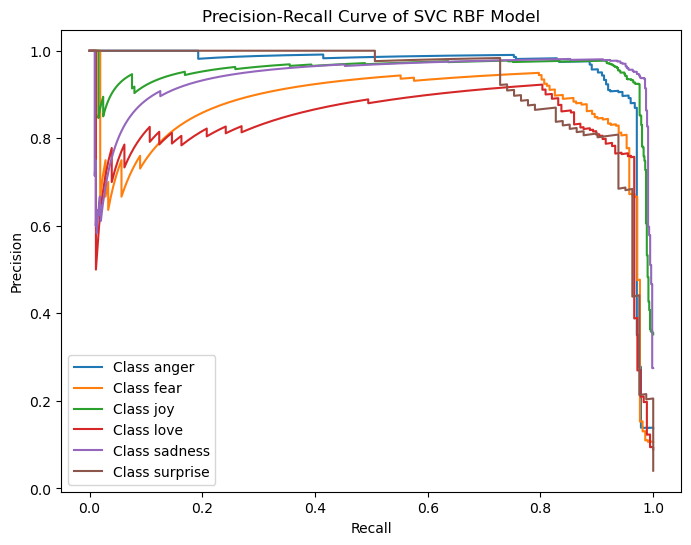

In [17]:
fine_tuned_model.to(device)

# Get embeddings for training and validation texts
x_train_bert = get_bert_embeddings(train_texts, fine_tuned_model, fine_tuned_tokenizer, device)
x_val_bert = get_bert_embeddings(val_texts, fine_tuned_model, fine_tuned_tokenizer, device)

# Fit the SVM model using fine-tuned BERT embeddings for training texts
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(x_train_bert, train_labels)

# Make predictions on the validation data
val_predictions = svm_model.predict(x_val_bert)

# Print classification report for validation data
print("Classification Report on Validation Data (SVC RBF):")
print(classification_report(val_labels, val_predictions))

# Get predicted probabilities for the validation set
val_probabilities = svm_model.predict_proba(x_val_bert)

# For binary classification, use the positive class probabilities
# Otherwise, loop through classes for multi-class
precision = {}
recall = {}
plt.figure(figsize=(8, 6))

for i, label in enumerate(svm_model.classes_):
    # Get binary labels for this class
    binary_labels = [1 if y == label else 0 for y in val_labels]
    
    # Get precision-recall data for each class
    precision[label], recall[label], _ = precision_recall_curve(
        binary_labels,  # Binary labels for this class
        val_probabilities[:, i]  # Probability for this class
    )

    # Plot each class's curve
    plt.plot(recall[label], precision[label], label=f"Class {label}")

# Customize plot
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve of SVC RBF Model")
plt.legend(loc="best")
plt.show()


### Trying different C and gamma values

In [49]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Initialize the GridSearchCV object with accuracy scoring
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid.fit(x_train_bert, train_labels)

# Extract the results into a DataFrame
results = pd.DataFrame(grid.cv_results_)

# Plot the results of the grid search
plt.figure(figsize=(10, 8))
sns.heatmap(results.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, cmap='viridis')
plt.title('Grid Search Mean Test Scores')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()
# Use the best estimator from the grid search
best_svm_model = grid.best_estimator_

# Make predictions on the validation data using the best SVM model
val_predictions_best = best_svm_model.predict(x_val_bert)

# Print classification report for validation data using the best SVM model
print("Classification Report on Validation Data (Best SVM Model):")
print(classification_report(val_labels, val_predictions_best))


Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

In [47]:
print(results[['param_C', 'param_gamma', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5))

   param_C param_gamma  mean_test_score  rank_test_score
12     100           1         0.449231                1
8       10           1         0.442479                2
13     100         0.1         0.436581                3
4        1           1         0.436239                4
9       10         0.1         0.431966                5


In [18]:
# Print the results of the testing data
for id, prediction in zip(val_texts, val_predictions):
    print(f"ID: {id} \nPrediction: {prediction}")

ID: ﻿im feeling quite sad and sorry for myself but ill snap out of it soon 
Prediction: sadness
ID: i feel like i am still looking at a blank canvas blank pieces of paper 
Prediction: sadness
ID: i feel like a faithful servant 
Prediction: love
ID: i am just feeling cranky and blue 
Prediction: anger
ID: i can have for a treat or if i am feeling festive 
Prediction: joy
ID: i start to feel more appreciative of what god has done for me 
Prediction: joy
ID: i am feeling more confident that we will be able to take care of this baby 
Prediction: joy
ID: i feel incredibly lucky just to be able to talk to her 
Prediction: joy
ID: i feel less keen about the army every day 
Prediction: joy
ID: i feel dirty and ashamed for saying that 
Prediction: sadness
ID: i feel bitchy but not defeated yet 
Prediction: anger
ID: i was dribbling on mums coffee table looking out of the window and feeling very happy 
Prediction: joy
ID: i woke up often got up around am feeling pukey radiation and groggy 
Predi

In [19]:
def predict_emotion(text, bert_model, tokenizer, svm_model, device):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get BERT embeddings
    with torch.no_grad():
        outputs = fine_tuned_model(**inputs)
        cls_embedding = outputs.logits.cpu().numpy()
    
    # Predict emotion using the SVM model
    prediction = svm_model.predict(cls_embedding)
    return prediction[0]

# Example usage
input_text = "I feel very happy today!"
predicted_emotion = predict_emotion(input_text, fine_tuned_model, fine_tuned_tokenizer, svm_model, device)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: joy


In [22]:
while True:
    user_input = input("Enter a text (or type 'exit' to stop): ")
    if user_input.lower() == 'exit' or user_input.lower() == '':
        break
    predicted_emotion = predict_emotion(user_input, fine_tuned_model, fine_tuned_tokenizer, svm_model, device)
    print(f"Text entered: {user_input}")
    print(f"Predicted Emotion: {predicted_emotion}")

Text entered: i want to rizz you
Predicted Emotion: joy
Text entered: i want to rizz your gyatt
Predicted Emotion: joy
